# Sales Forecasting

In [104]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

In [105]:
df = pd.read_csv(r'C:\Users\priya\Desktop\Train.csv')

In [26]:
df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


## EDA

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB


In [28]:
df.isnull().sum()

ID               0
Store_id         0
Store_Type       0
Location_Type    0
Region_Code      0
Date             0
Holiday          0
Discount         0
#Order           0
Sales            0
dtype: int64

In [29]:
df.duplicated().sum()

0

In [48]:
df.rename(columns={'#Order':'Order'},inplace=True)
df.drop('ID',axis=1,inplace=True)
df['Date']=pd.to_datetime(df['Date'])

In [49]:
df['Discount'] = df['Discount'].map({'Yes': 1, 'No': 0})

In [32]:
df.dtypes

Store_id                  int64
Store_Type               object
Location_Type            object
Region_Code              object
Date             datetime64[ns]
Holiday                   int64
Discount                  int64
Order                     int64
Sales                   float64
dtype: object

In [50]:
# Extract year, month, and day from 'Date' column
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [34]:
df.describe()

,Store_id,Holiday,Discount,Order,Sales,Year,Month,Day
count,188340.000000,188340.000000,188340.000000,188340.000000,188340.000000,188340.000000,188340.000000,188340.000000
mean,183.000000,0.131783,0.447536,68.205692,42784.327982,2018.292636,5.498062,15.691860
std,105.366308,0.338256,0.497241,30.467415,18456.708302,0.454974,3.399450,8.783156
min,1.000000,0.000000,0.000000,0.000000,0.000000,2018.000000,1.000000,1.000000
25%,92.000000,0.000000,0.000000,48.000000,30426.000000,2018.000000,3.000000,8.000000
50%,183.000000,0.000000,0.000000,63.000000,39678.000000,2018.000000,5.000000,16.000000
75%,274.000000,0.000000,1.000000,82.000000,51909.000000,2019.000000,8.000000,23.000000
max,365.000000,1.000000,1.000000,371.000000,247215.000000,2019.000000,12.000000,31.000000


In [35]:
df.describe(include=object)

,Store_Type,Location_Type,Region_Code
count,188340,188340,188340
unique,4,5,4
top,S1,L1,R1
freq,88752,85140,63984


In [36]:
# Convert categorical columns to category type
categorical_cols = ['Store_Type', 'Location_Type', 'Region_Code', 'Holiday', 'Discount']
for col in categorical_cols:
    df[col] = df[col].astype('category')

In [37]:
df.head()

,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Order,Sales,Year,Month,Day
0,1,S1,L3,R1,2018-01-01,1,1,9,7011.84,2018,1,1
1,253,S4,L2,R1,2018-01-01,1,1,60,51789.12,2018,1,1
2,252,S3,L2,R1,2018-01-01,1,1,42,36868.20,2018,1,1
3,251,S2,L3,R1,2018-01-01,1,1,23,19715.16,2018,1,1
4,250,S2,L3,R4,2018-01-01,1,1,62,45614.52,2018,1,1


In [38]:
df.dtypes

Store_id                  int64
Store_Type             category
Location_Type          category
Region_Code            category
Date             datetime64[ns]
Holiday                category
Discount               category
Order                     int64
Sales                   float64
Year                      int64
Month                     int64
Day                       int64
dtype: object

In [39]:
# One-hot encode categorical variables
#df1 = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

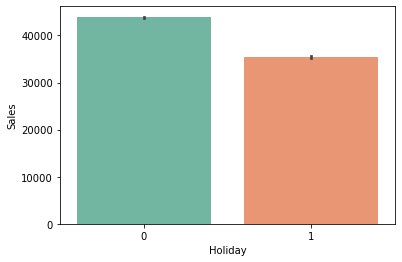

In [41]:
sns.barplot(x='Holiday',y='Sales',data=df, palette='Set2')
plt.show()

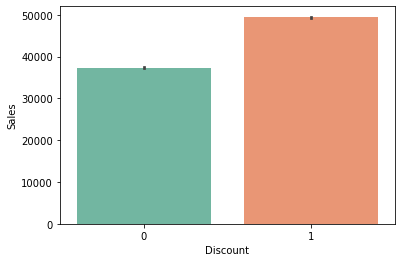

In [42]:
sns.barplot(x='Discount',y='Sales',data=df, palette= 'Set2')
plt.show()

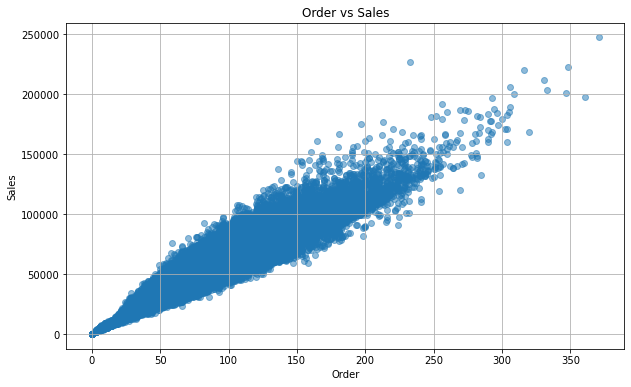

In [43]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Order'], df['Sales'], alpha=0.5)
plt.title('Order vs Sales')
plt.xlabel('Order')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

Shows linear relationship between order and sales

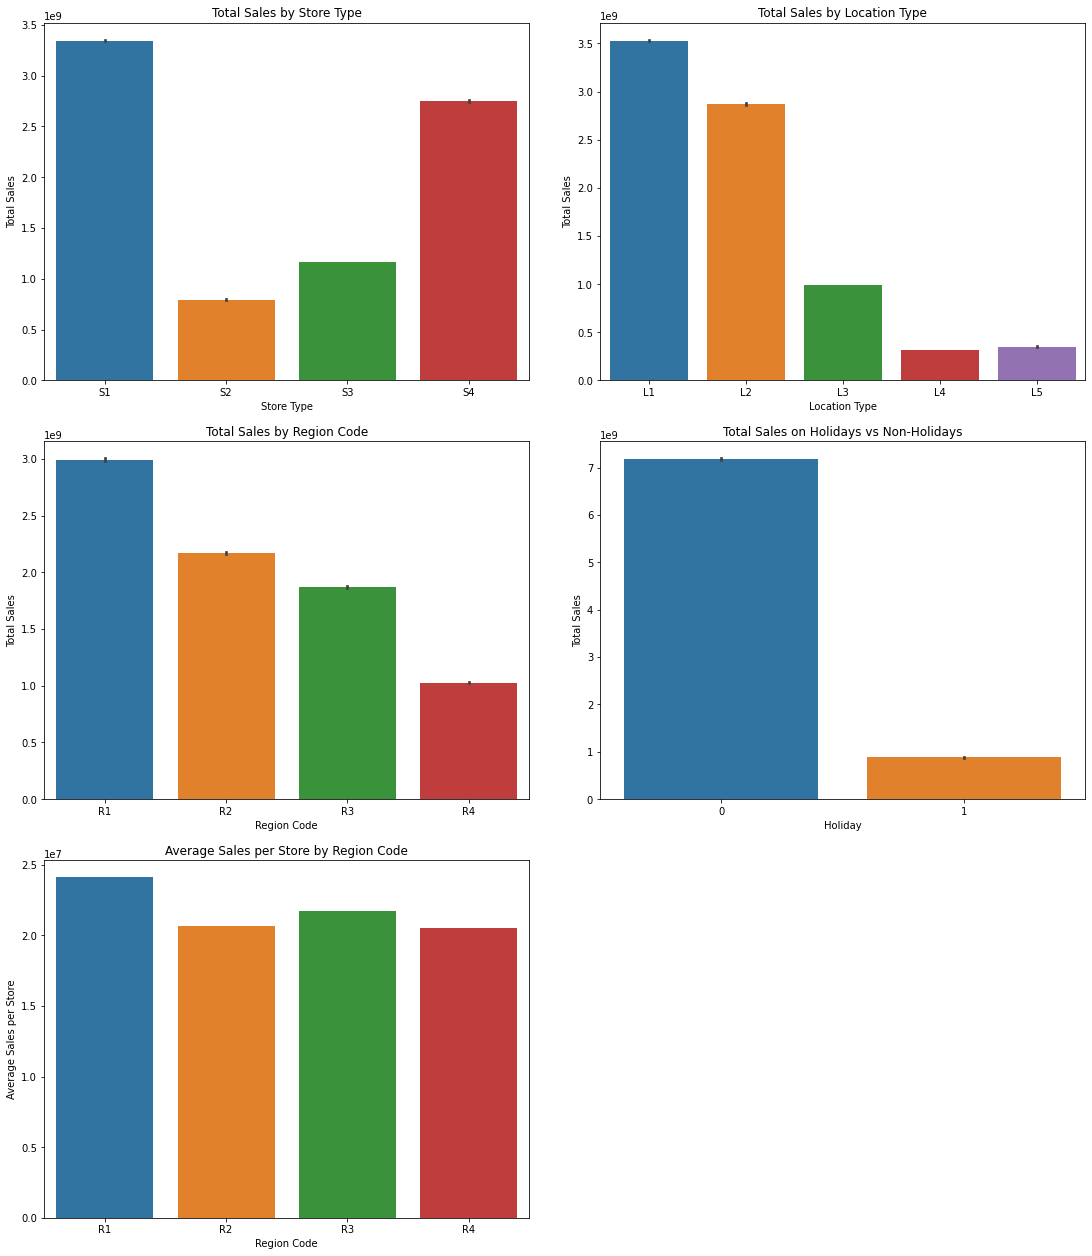

In [44]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# Adjust the layout
plt.tight_layout(pad=4.0)

# Plot: Store Type vs Sales
sns.barplot(x='Store_Type', y='Sales', data=df, estimator=sum, ax=axes[0, 0])
axes[0, 0].set_title('Total Sales by Store Type')
axes[0, 0].set_xlabel('Store Type')
axes[0, 0].set_ylabel('Total Sales')

# Plot: Location Type vs Sales
sns.barplot(x='Location_Type', y='Sales', data=df, estimator=sum, ax=axes[0, 1])
axes[0, 1].set_title('Total Sales by Location Type')
axes[0, 1].set_xlabel('Location Type')
axes[0, 1].set_ylabel('Total Sales')

# Plot: Region Code vs Sales
sns.barplot(x='Region_Code', y='Sales', data=df, estimator=sum, ax=axes[1, 0])
axes[1, 0].set_title('Total Sales by Region Code')
axes[1, 0].set_xlabel('Region Code')
axes[1, 0].set_ylabel('Total Sales')

# Plot: Holiday vs Sales
sns.barplot(x='Holiday', y='Sales', data=df, estimator=sum, ax=axes[1, 1])
axes[1, 1].set_title('Total Sales on Holidays vs Non-Holidays')
axes[1, 1].set_xlabel('Holiday')
axes[1, 1].set_ylabel('Total Sales')

# Calculate Average Sales per Store for Region Code
avg_sales_per_store = df.groupby('Region_Code').agg({'Sales': 'sum', 'Store_id': 'nunique'})
avg_sales_per_store['avg_sales_per_store'] = avg_sales_per_store['Sales'] / avg_sales_per_store['Store_id']

# Plot: Average Sales per Store by Region Code
sns.barplot(x=avg_sales_per_store.index, y=avg_sales_per_store['avg_sales_per_store'], ax=axes[2, 0])
axes[2, 0].set_title('Average Sales per Store by Region Code')
axes[2, 0].set_xlabel('Region Code')
axes[2, 0].set_ylabel('Average Sales per Store')

# Remove the empty subplot
fig.delaxes(axes[2, 1])

# Show the figure
plt.show()

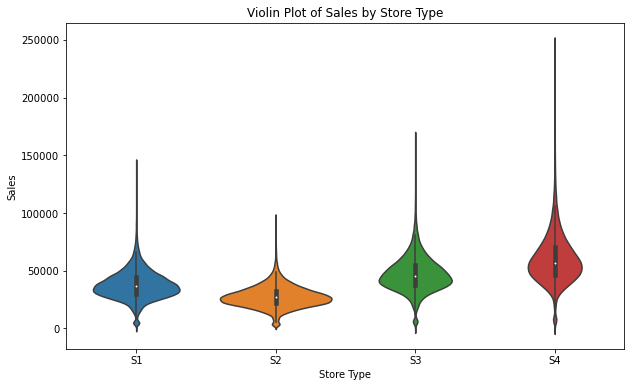

In [45]:
# Violin Plot of Sales by Store Type
plt.figure(figsize=(10, 6))
sns.violinplot(x='Store_Type',  y='Sales', data=df)
plt.title('Violin Plot of Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

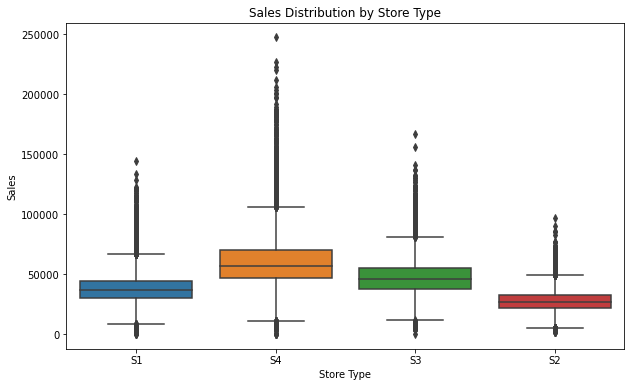

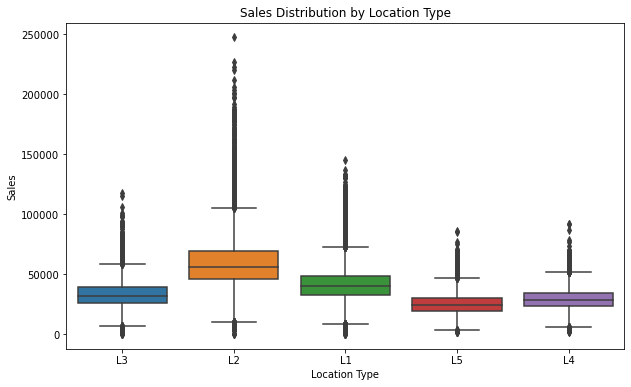

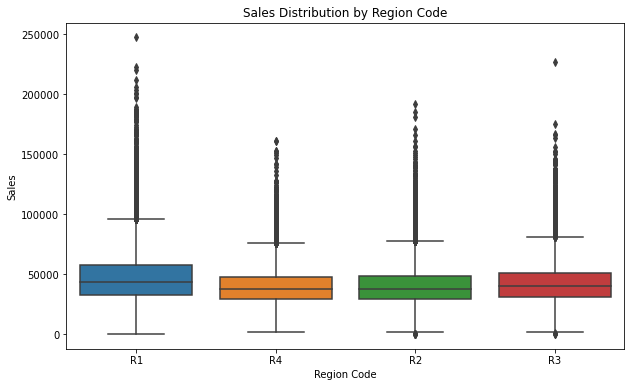

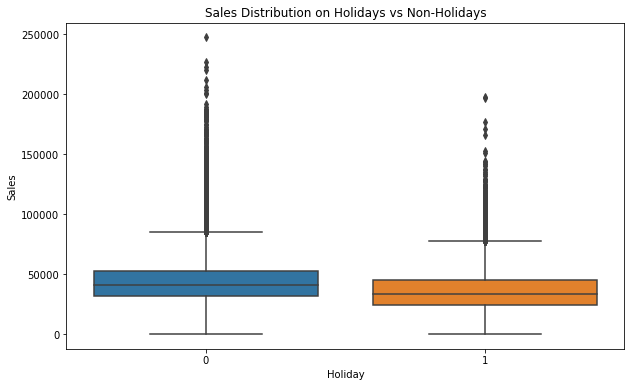

<Figure size 720x432 with 0 Axes>

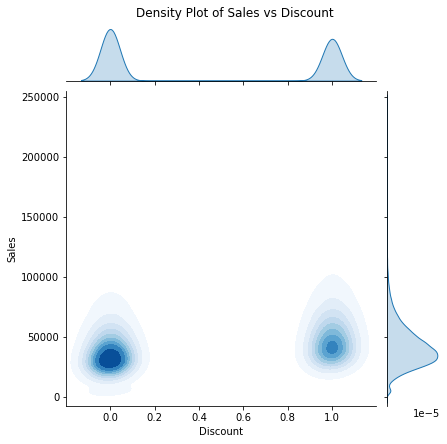

<Figure size 864x576 with 0 Axes>

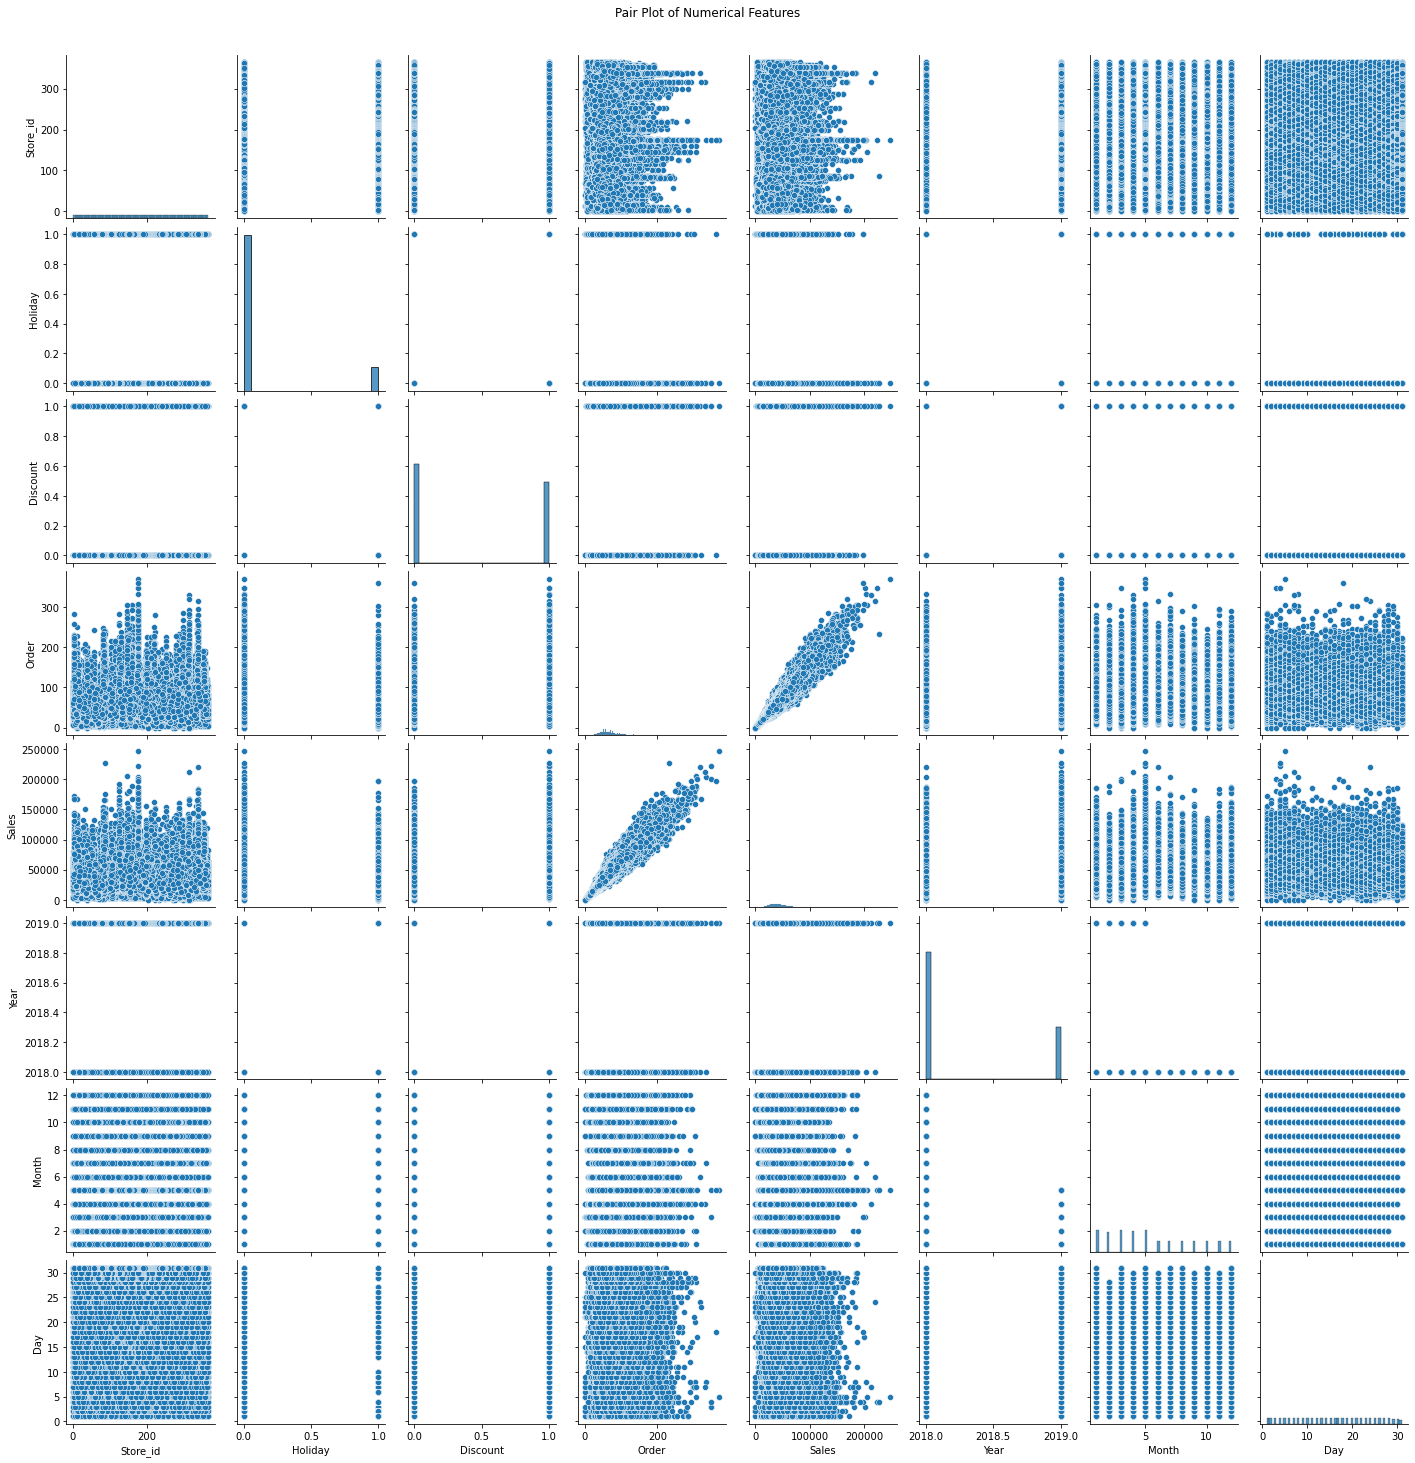

In [51]:
# Store Type vs Sales Distribution (Box Plot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Store_Type', y='Sales', data=df)
plt.title('Sales Distribution by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

# Location Type vs Sales Distribution (Box Plot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Location_Type', y='Sales', data=df)
plt.title('Sales Distribution by Location Type')
plt.xlabel('Location Type')
plt.ylabel('Sales')
plt.show()

# Region Code vs Sales Distribution (Box Plot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Region_Code',  y='Sales', data=df)
plt.title('Sales Distribution by Region Code')
plt.xlabel('Region Code')
plt.ylabel('Sales')
plt.show()

# Holiday vs Sales Distribution (Box Plot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Holiday',  y='Sales', data=df)
plt.title('Sales Distribution on Holidays vs Non-Holidays')
plt.xlabel('Holiday')
plt.ylabel('Sales')
plt.show()

# Discount vs Sales Density Plot
plt.figure(figsize=(10, 6))
sns.jointplot(x='Discount', y='Sales', data=df, kind='kde', fill=True, cmap="Blues")
plt.suptitle('Density Plot of Sales vs Discount', y=1.02)
plt.xlabel('Discount')
plt.ylabel('Sales')
plt.show()

# Pair Plot of all Numerical Features
plt.figure(figsize=(12, 8))
sns.pairplot(df)
plt.suptitle('Pair Plot of Numerical Features', y=1.02)
plt.show()

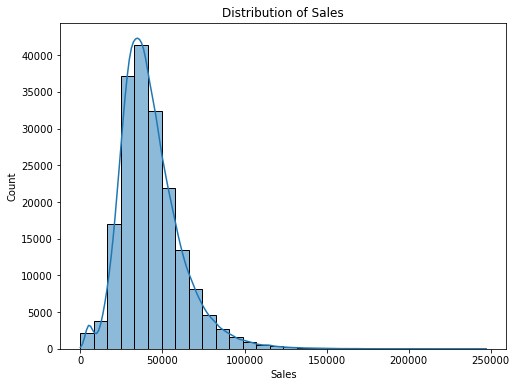

In [52]:
# Distribution of Sales
plt.figure(figsize=(8, 6))
sns.histplot(df['Sales'], bins=30, kde=True)
plt.title('Distribution of Sales')
plt.show()

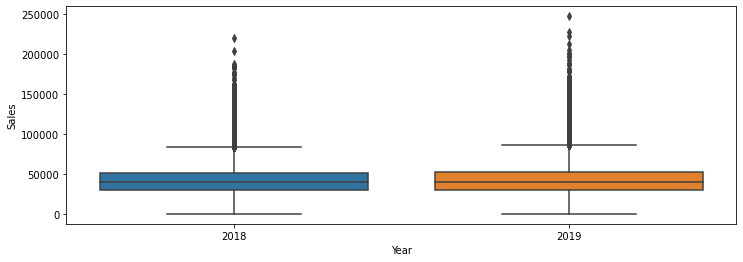

In [53]:
# check for outliers in Sales.
plt.figure(figsize=(12, 4))
sns.boxplot(data=df, x='Year', y='Sales')
plt.show()

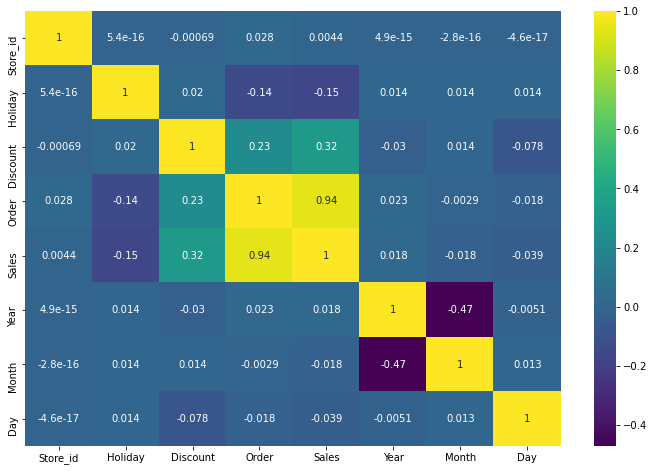

In [54]:
# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='viridis')
plt.show()

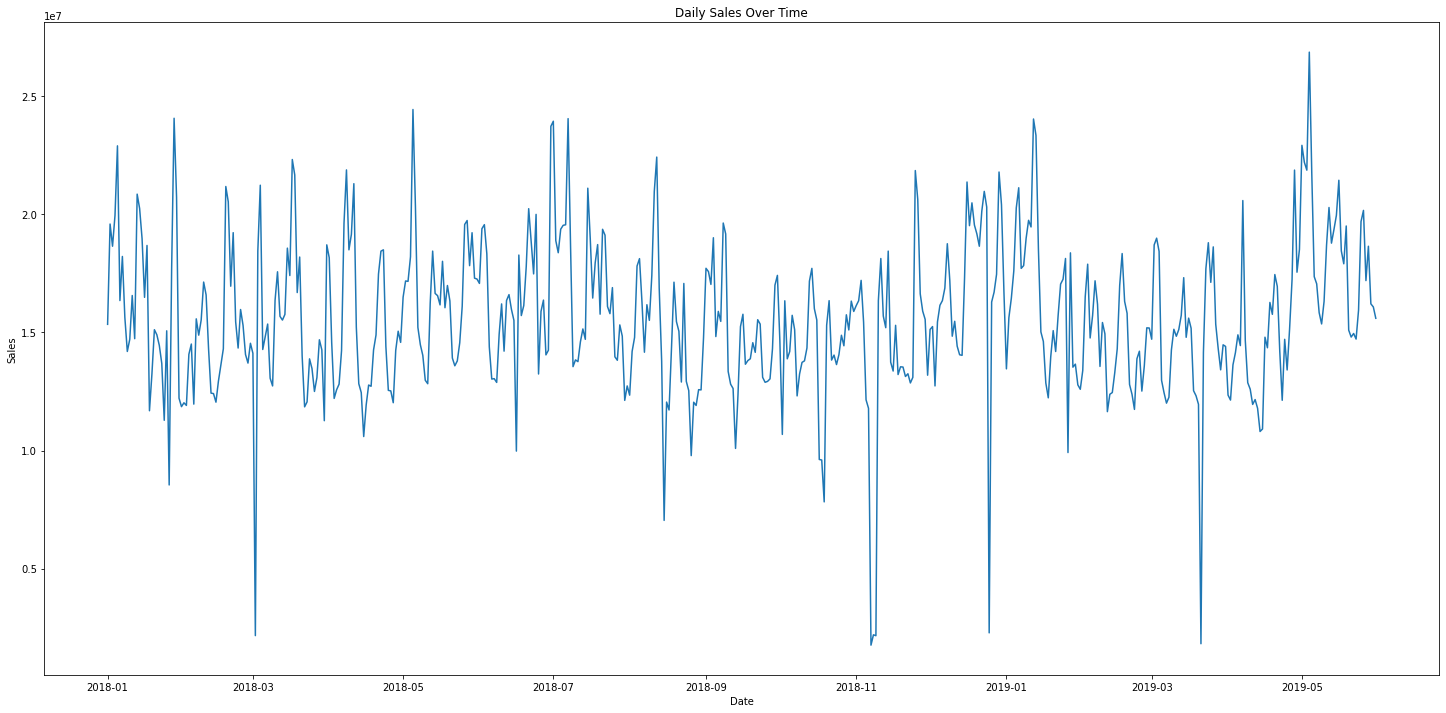

In [60]:
# Aggregate sales data by date
daily_sales = df.groupby('Date')['Sales'].sum().reset_index()

# Plot the aggregated sales data
import matplotlib.pyplot as plt

plt.figure(figsize=(25,12))
plt.plot(daily_sales['Date'], daily_sales['Sales'])
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


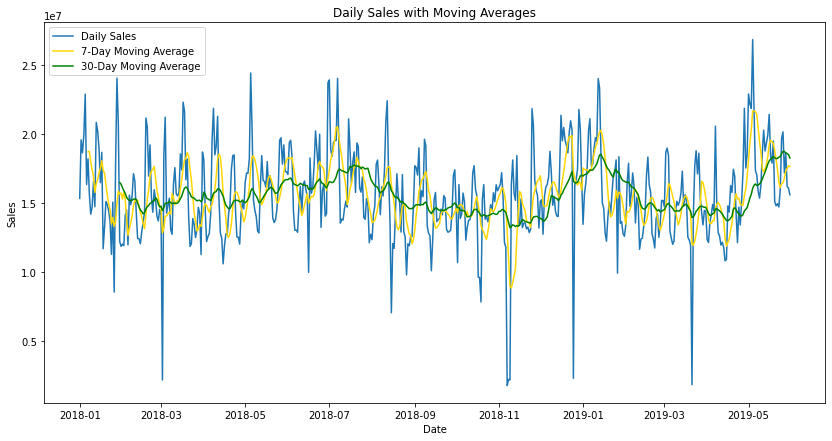

In [61]:
# Compute moving averages
daily_sales['Sales_MA_7'] = daily_sales['Sales'].rolling(window=7).mean()  # 7-day moving average
daily_sales['Sales_MA_30'] = daily_sales['Sales'].rolling(window=30).mean()  # 30-day moving average

# Plot the sales data with moving averages
plt.figure(figsize=(14, 7))
plt.plot(daily_sales['Date'], daily_sales['Sales'], label='Daily Sales')
plt.plot(daily_sales['Date'], daily_sales['Sales_MA_7'], label='7-Day Moving Average', color='gold')
plt.plot(daily_sales['Date'], daily_sales['Sales_MA_30'], label='30-Day Moving Average', color='green')
plt.title('Daily Sales with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


The moving averages help to smooth out the short-term fluctuations and highlight longer-term trends.

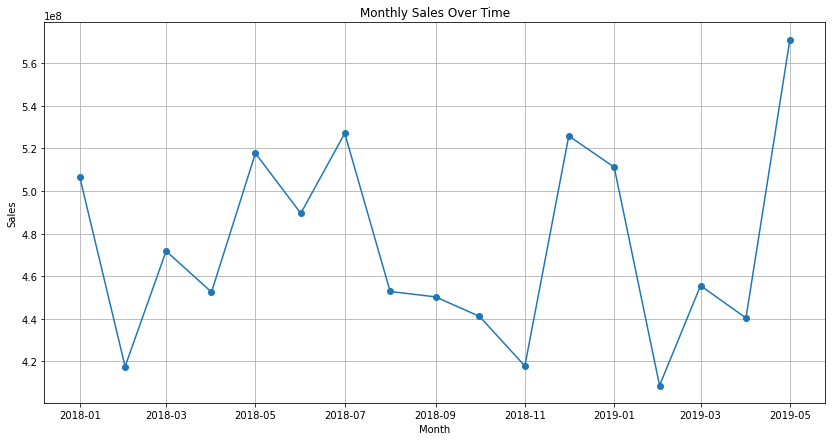

In [75]:
monthly_sales = df.groupby(['Year', 'Month'])['Sales'].sum().reset_index()

# Convert Year and Month to a datetime object for plotting
monthly_sales['Date'] = pd.to_datetime(monthly_sales[['Year', 'Month']].assign(DAY=1))

# Plot the monthly sales data
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales['Date'], monthly_sales['Sales'], marker='o')
plt.title('Monthly Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

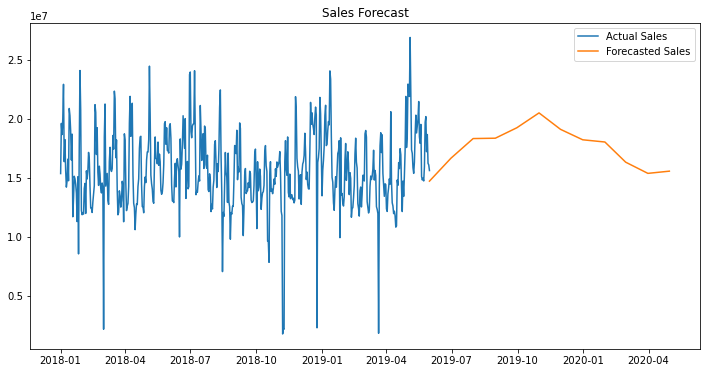

In [77]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Aggregate sales by date
ts_data = df.groupby('Date')['Sales'].sum().reset_index()

# Initialize and fit the model
model = ExponentialSmoothing(ts_data['Sales'], seasonal='add', seasonal_periods=12).fit()

# Forecast future sales
forecast = model.forecast(steps=12)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(ts_data['Date'], ts_data['Sales'], label='Actual Sales')
plt.plot(pd.date_range(start=ts_data['Date'].iloc[-1], periods=12, freq='M'), forecast, label='Forecasted Sales')
plt.title('Sales Forecast')
plt.legend()
plt.show()

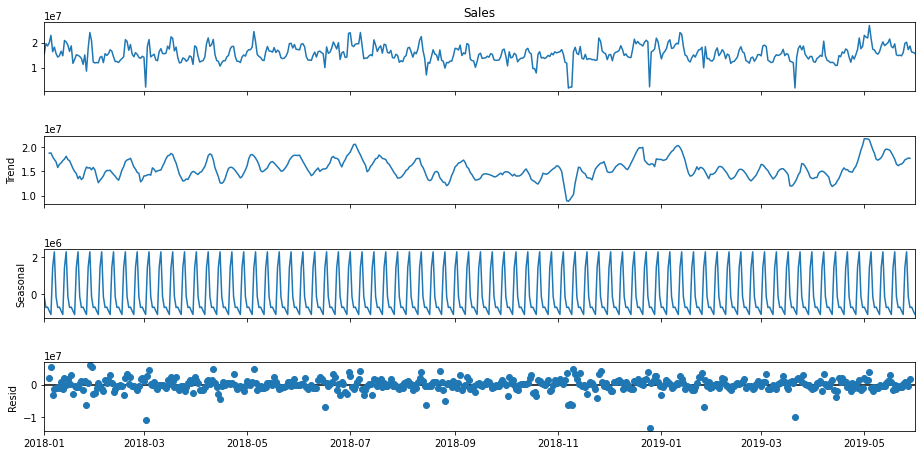

In [62]:
# Set the date as the index for time series decomposition
daily_sales.set_index('Date', inplace=True)

# Perform STL decomposition
stl = sm.tsa.seasonal_decompose(daily_sales['Sales'], model='additive')
stl_plot = stl.plot()
stl_plot.set_size_inches(14, 7)
plt.show()

### Autocorrelation Analysis

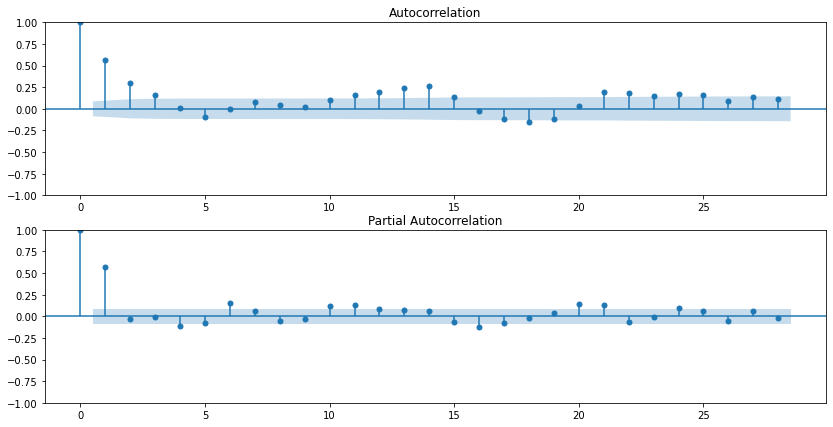

In [63]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, ax = plt.subplots(2, figsize=(14, 7))

plot_acf(daily_sales['Sales'], ax=ax[0])
plot_pacf(daily_sales['Sales'], ax=ax[1])

plt.show()


## Interpretation of ADF Test Results
- ADF Statistic: This is the test statistic value. A more negative value indicates stronger evidence against the null hypothesis.
- p-value: This is the probability that the data is non-stationary. A smaller p-value indicates stronger evidence against the null hypothesis.
## Null and Alternative Hypotheses
- Null Hypothesis (H0): The time series has a unit root (i.e., it is non-stationary).
- Alternative Hypothesis (H1): The time series does not have a unit root (i.e., it is stationary).

In [64]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(daily_sales['Sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -3.5242079065633236
p-value: 0.00738671871136226


Observation:
- ADF Statistic of -3.5242 and p-value of 0.0074 indicate that the null hypothesis can be rejected at the 5% significance level.
- This suggests that the time series is stationary.

### ARIMA Model

In [65]:
from statsmodels.tsa.arima.model import ARIMA
results = []
for p in range(0, 5):
    for q in range(0, 5):
        model = ARIMA(daily_sales['Sales'], order=(p, 0, q))  # assuming d=0 as the data is stationary
        result = model.fit()
        aic = result.aic
        bic = result.bic
        results.append((p, q, aic, bic))

best_aic_model = min(results, key=lambda x: x[2])  # model with lowest AIC
best_bic_model = min(results, key=lambda x: x[3])  # model with lowest BIC

print(f'Best AIC Model: p={best_aic_model[0]}, q={best_aic_model[1]}, AIC={best_aic_model[2]}')
print(f'Best BIC Model: p={best_bic_model[0]}, q={best_bic_model[1]}, BIC={best_bic_model[3]}')


Best AIC Model: p=3, q=2, AIC=16714.78888497227
Best BIC Model: p=3, q=2, BIC=16744.51163233064


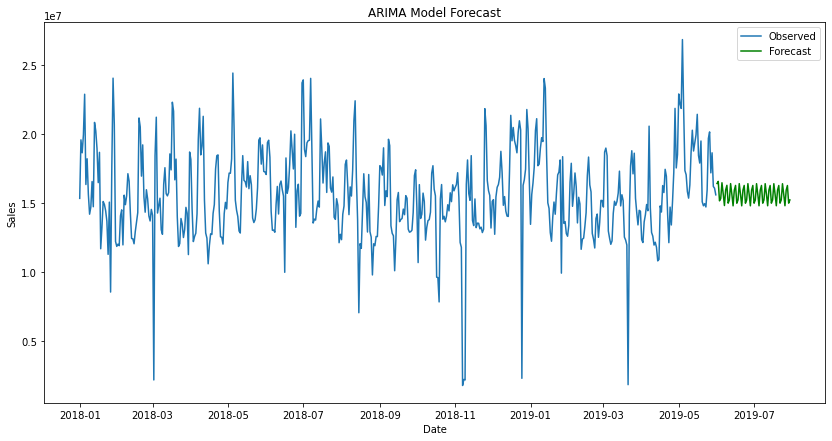

In [66]:
# Fit the ARIMA model
model = ARIMA(daily_sales['Sales'], order=(3, 0, 2))
arima_result = model.fit()

# Forecast future values
forecast = arima_result.forecast(steps=60)  # Forecast for the next 60 days

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(daily_sales['Sales'], label='Observed')
plt.plot(forecast, label='Forecast', color='green')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [67]:
# Split the data
train, test = train_test_split(df, test_size=0.2, shuffle=False)

In [68]:
# ARIMA model
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train['Sales'], order=(3,0,2))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=len(test))
arima_rmse = np.sqrt(mean_squared_error(test['Sales'], arima_forecast))
print('ARIMA RMSE:', arima_rmse)



ARIMA RMSE: 19823.497982611407


In [ ]:
# # Prophet model
# from prophet import Prophet

# prophet_data = train.reset_index().rename(columns={'Date': 'ds', 'Sales': 'y'})
# prophet_model = Prophet()
# prophet_model.fit(prophet_data)
# prophet_future = prophet_model.make_future_dataframe(periods=len(test))
# prophet_forecast = prophet_model.predict(prophet_future)
# prophet_rmse = np.sqrt(mean_squared_error(test['Sales'], prophet_forecast[-len(test):]['yhat']))
# print('Prophet RMSE:', prophet_rmse)



### Sarimax Model

#### Differencing:

- Regular Differencing (d): Apply differencing to remove trends and make the series stationary.
- Seasonal Differencing (D): Apply seasonal differencing to remove seasonal effects.

## Interpretation of ADF Test Results
- ADF Statistic: This is the test statistic value. A more negative value indicates stronger evidence against the null hypothesis.
- p-value: This is the probability that the data is non-stationary. A smaller p-value indicates stronger evidence against the null hypothesis.
## Null and Alternative Hypotheses
- Null Hypothesis (H0): The time series has a unit root (i.e., it is non-stationary).
- Alternative Hypothesis (H1): The time series does not have a unit root (i.e., it is stationary).

In [71]:
# Regular differencing to remove trend
data_diff = df['Sales'].diff().dropna()
result = adfuller(data_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Seasonal differencing to remove seasonality
data_seasonal_diff = df['Sales'].diff(12).dropna()
result_seasonal = adfuller(data_seasonal_diff)
print('Seasonal ADF Statistic:', result_seasonal[0])
print('Seasonal p-value:', result_seasonal[1])


ADF Statistic: -75.26223018361681
p-value: 0.0
Seasonal ADF Statistic: -66.10187984531385
Seasonal p-value: 0.0


ADF Statistic: -75.26223018361681, p-value: 0.0:

ADF Statistic: The highly negative value suggests strong evidence against the null hypothesis.
p-value: A p-value of 0.0 means there is strong evidence against the null hypothesis, indicating that the time series is stationary.
Seasonal ADF Statistic: -66.10187984531385, Seasonal p-value: 0.0:

Seasonal ADF Statistic: Similarly, the highly negative value indicates strong evidence against the null hypothesis for the seasonally differenced data.
Seasonal p-value: A p-value of 0.0 indicates strong evidence that the seasonally differenced series is stationary.

#### Auto-correlation Function (ACF) and Partial Auto-correlation Function (PACF):

- ACF: Helps to determine the q and Q parameters.
- PACF: Helps to determine the p and P parameters.


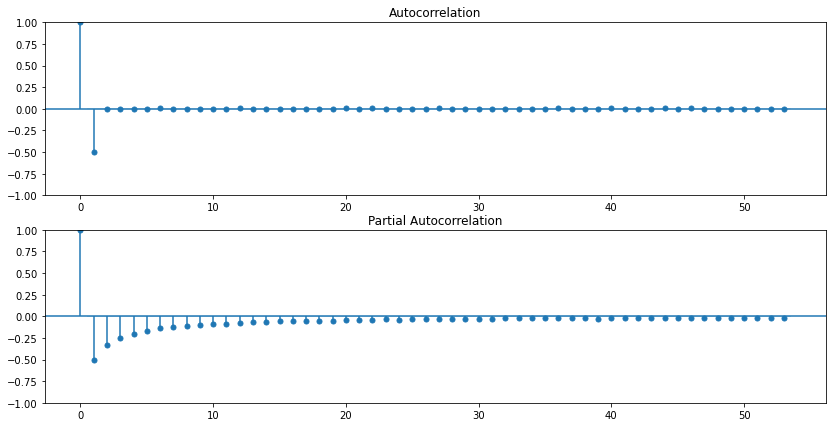

In [72]:
fig, ax = plt.subplots(2, figsize=(14, 7))

plot_acf(data_diff, ax=ax[0])
plot_pacf(data_diff, ax=ax[1])

plt.show()


In [73]:
# SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train['Sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()
sarima_forecast = sarima_result.get_forecast(steps=len(test)).predicted_mean
sarima_rmse = np.sqrt(mean_squared_error(test['Sales'], sarima_forecast))
print('SARIMA RMSE:', sarima_rmse)


SARIMA RMSE: 21110.66070571907


In [84]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Encode categorical variables
label_encoders = {}
categorical_features = df.select_dtypes(include=[object]).columns.tolist()
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Feature scaling
scaler = StandardScaler()
# Get all numerical columns
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist() 

# Identify and handle datetime column
datetime_column = None
for col in df.columns:
    if df[col].dtype == 'datetime64[ns]':  # Check for datetime dtype
        datetime_column = col
        # Drop the datetime column
        df = df.drop(datetime_column, axis=1) 
        break  # Stop after finding the first datetime column

# Scale numerical features (excluding the handled datetime column)
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Split the Data
X = df.drop('Sales', axis=1)  # Features
y = df['Sales']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ... (rest of the code remains the same)

# Train Multiple Machine Learning Models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

# Dictionary to store the results
results = {}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    # Make predictions
    y_pred = model.predict(X_test)
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    results[model_name] = {'MSE': mse, 'R2': r2, 'MAPE': mape}
    print(f"{model_name} - MSE: {mse}, R2: {r2}, MAPE: {mape}")

# Evaluate and Compare the Models
results_df = pd.DataFrame(results).T
print(results_df)

# Determine the best model based on the lowest MAPE score
best_model = results_df['MAPE'].idxmin()
print(f"The best model is: {best_model} based on the MAPE score")

Linear Regression - MSE: 0.08905105560630712, R2: 0.9102710188396229, MAPE: 1.5626909137293152
Decision Tree - MSE: 0.05220379706448319, R2: 0.9473987872304638, MAPE: 0.9972026961676167
Random Forest - MSE: 0.02553595436474964, R2: 0.9742696461877248, MAPE: 0.7690712142695472
Gradient Boosting - MSE: 0.04144026652981594, R2: 0.958244258089721, MAPE: 1.1057065830855302
                        MSE        R2      MAPE
Linear Regression  0.089051  0.910271  1.562691
Decision Tree      0.052204  0.947399  0.997203
Random Forest      0.025536  0.974270  0.769071
Gradient Boosting  0.041440  0.958244  1.105707
The best model is: Random Forest based on the MAPE score


In [74]:
# Machine Learning Models (Random Forest)
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(train.index.values.reshape(-1, 1), train['Sales'])
rf_forecast = rf_model.predict(test.index.values.reshape(-1, 1))
rf_rmse = np.sqrt(mean_squared_error(test['Sales'], rf_forecast))
print('Random Forest RMSE:', rf_rmse)

Random Forest RMSE: 27925.87805962594


In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the model
rf = RandomForestRegressor()

# Initialize Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit Grid Search
grid_search.fit(train.index.values.reshape(-1, 1), train['Sales'])

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the model with the best parameters
best_rf_model = RandomForestRegressor(**best_params)
best_rf_model.fit(train.index.values.reshape(-1, 1), train['Sales'])

# Make predictions
rf_forecast = best_rf_model.predict(test.index.values.reshape(-1, 1))

# Calculate RMSE
rf_rmse = np.sqrt(mean_squared_error(test['Sales'], rf_forecast))
print('Random Forest RMSE:', rf_rmse)


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest RMSE: 24614.809201582775


In [91]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA

# Load the data
train_data = pd.read_csv(r'C:\Users\priya\Desktop\Train.csv')
test_data =pd.read_csv(r'C:\Users\priya\Desktop\Test_final.csv')

# Preprocess the data
def preprocess_data(df):
    df['Date'] = pd.to_datetime(df['Date'])
    le = LabelEncoder()
    for column in ['Store_Type', 'Location_Type', 'Region_Code', 'Discount']:
        df[column] = le.fit_transform(df[column])
    return df

train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Random Forest Regression
# Separate features and target variable in the training data
X_train = train_data.drop(columns=['ID', 'Date', 'Sales', '#Order'])
y_train = train_data['Sales']

# Define the best parameters (from previous grid search)
best_params = {
    'bootstrap': True,
    'max_depth': 10,
    'max_features': 'sqrt',
    'min_samples_leaf': 4,
    'min_samples_split': 5,
    'n_estimators': 100
}

# Train the Random Forest regression model with the best parameters
best_rf_model = RandomForestRegressor(**best_params)
best_rf_model.fit(X_train, y_train)

# Prepare test features
X_test = test_data.drop(columns=['ID', 'Date'])

# Make predictions
rf_forecast = best_rf_model.predict(X_test)

# Since the test data might not have 'Sales' for evaluation, we will use a validation split on train data
# Split the training data for validation
X_train_split, X_valid, y_train_split, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train the model on the split training data with the best parameters
best_rf_model_split = RandomForestRegressor(**best_params)
best_rf_model_split.fit(X_train_split, y_train_split)

# Predict on the validation set
y_valid_pred = best_rf_model_split.predict(X_valid)

# Evaluate the model
rf_mse = mean_squared_error(y_valid, y_valid_pred)
rf_r2 = r2_score(y_valid, y_valid_pred)
rf_mape = mean_absolute_percentage_error(y_valid, y_valid_pred)
rf_rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))

print(f"Random Forest MSE: {rf_mse}")
print(f"Random Forest R2: {rf_r2}")
print(f"Random Forest MAPE: {rf_mape}")
print(f"Random Forest RMSE: {rf_rmse}")

Random Forest MSE: 126026589.31527483
Random Forest R2: 0.6272225299719176
Random Forest MAPE: 9031318719465136.0
Random Forest RMSE: 11226.156480081454


In [95]:
import pickle

# Save the best performing model (either Random Forest or Gradient Boosting)
model_filename = 'best_model.pkl'
best_model = best_rf_model

with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)
